In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import anacal
import lsst.geom as geom
from lsst.skymap.ringsSkyMap import (
    RingsSkyMap, RingsSkyMapConfig
)
from xlens.simulator.catalog import (
    CatalogHaloTask,
    CatalogHaloTaskConfig,
)
from xlens.simulator.sim import (
    MultibandSimConfig, MultibandSimTask
)

from astropy.visualization import simple_norm

In [2]:
config = RingsSkyMapConfig()
config.patchInnerDimensions = [1001, 1001]
config.tractOverlap = 0.0
config.patchBorder = 0        # pixels
config.numRings = 5000
config.pixelScale = 0.2
config.projection = "TAN"
skymap = RingsSkyMap(config=config)

In [17]:
mag_zero = 30.0
tract_id = 40000
config = CatalogHaloTaskConfig()
config.mass = 4e14
config.conc = 3.8
config.z_lens = 0.25
config.z_source = 1.0
config.layout="random"
cattask = CatalogHaloTask(config=config)
truthCatalog = cattask.run(
    tract_info=skymap[tract_id],
    seed=120,
).truthCatalog

config = MultibandSimConfig()
config.survey_name = "lsst"
simtask = MultibandSimTask(config=config)
outcome = simtask.run(
    tract_info=skymap[tract_id],
    patch_id=0,
    band="i",
    seed=120,
    truthCatalog=truthCatalog,
)

Text(0.5, 1.0, 'Exposure')

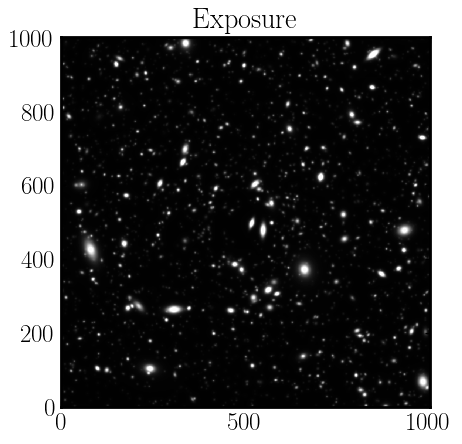

In [18]:
gal_array = outcome.simExposure.image.array
lsst_psf = outcome.simExposure.getPsf()
psf_array = np.asarray(
    anacal.utils.resize_array(
        lsst_psf.computeImage(geom.Point2D(500, 500)).getArray(), (64, 64)
    ),
    dtype=np.float64,
)

# Display the galaxy image simulation
plt.imshow(
    gal_array,
    aspect="equal",
    cmap="Greys_r",
    origin="lower",
    interpolation="None",
    norm=simple_norm(gal_array, "asinh", asinh_a=0.2, min_cut=-0.1, max_cut=30),
)
plt.title("Exposure")

Text(0.5, 1.0, 'PSF')

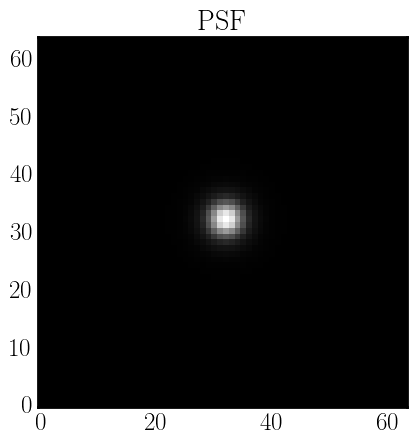

In [19]:
plt.close()
# Display the PSF image simulation
plt.imshow(psf_array, cmap="Greys_r", origin="lower")
plt.title("PSF")

In [20]:
# Run Anacal measurement
fpfs_config = anacal.fpfs.FpfsConfig(
    sigma_shapelets=0.52,  # base measruement kernel (for detection and e1, e2, q1, q2)
    sigma_shapelets1=0.45,  # kernel 1 (for e1_1, e2_1, q1_1, q2_1)
    sigma_shapelets2=0.55,  # kernel 2 (for e1_2, e2_2, q1_2, q2_2)
)
noise_variance = 0.37
pixel_scale = 0.2
out = anacal.fpfs.process_image(
    fpfs_config=fpfs_config,
    mag_zero=mag_zero,
    gal_array=gal_array,
    psf_array=psf_array,
    pixel_scale=pixel_scale,
    noise_variance=noise_variance,  # the detection threshold is determined from this (do not set it to zero)
    noise_array=None,  # image is noiseless, set it to None
    detection=None,  # if set to None, anacal will do detection
)

Text(0.5, 1.0, 'Exposure')

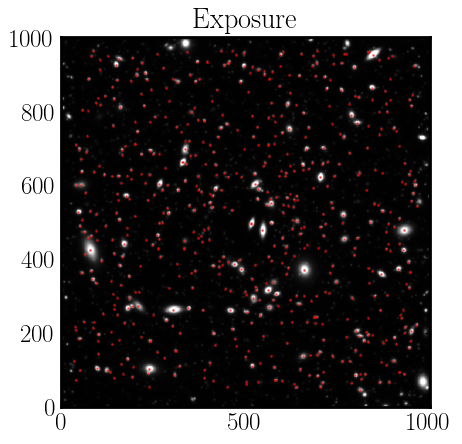

In [21]:
plt.close()
plt.scatter(out["x"], out["y"], marker="o", alpha=0.5, s=1.0, color="red")
# Display the galaxy image simulation
plt.imshow(
    gal_array,
    aspect="equal",
    cmap="Greys_r",
    origin="lower",
    interpolation="None",
    norm=simple_norm(gal_array, "asinh", asinh_a=0.2, min_cut=-0.1, max_cut=30),
)
plt.title("Exposure")

In [22]:
from xlens.analysis.cluster import HaloMcBiasMultibandPipe as pipe

In [23]:
e1 = out["fpfs_e1"]
e2 = out["fpfs_e2"]
e1_g1 = out["fpfs_de1_dg1"]
e2_g2 = out["fpfs_de2_dg2"]
w = out["fpfs_w"]
w_g1 = out["fpfs_dw_dg1"]
w_g2 = out["fpfs_dw_dg2"]
x = out["x"]
y = out["y"]

In [24]:
wcs_stack = skymap[tract_id].getWcs()
ra, dec = wcs_stack.pixelToSkyArray(x, y, degrees=True)

In [25]:
ra_lens = wcs_stack.getSkyOrigin().getRa().asDegrees()
dec_lens = wcs_stack.getSkyOrigin().getDec().asDegrees()
angle = pipe.position_angle_ccw_from_east(
    ra_lens,
    dec_lens,
    ra,
    dec
)
dist = pipe.angsep(ra, dec, ra_lens, dec_lens)

In [26]:
eT, eX = pipe._rotate_spin_2_vec(e1, e2, angle)
r11, r22 = pipe._get_response_from_w_and_der(
    e1,
    e2,
    w,
    e1_g1,
    e2_g2,
    w_g1,
    w_g2,
)
rT, rX = pipe._rotate_spin_2_vec(r11, r22, angle)

(array([  8.,  44.,  54.,  68.,  66.,  77., 114.,  97.,  54.,  21.]),
 array([  3.10483494,  15.3607177 ,  27.61660047,  39.87248323,
         52.12836599,  64.38424876,  76.64013152,  88.89601429,
        101.15189705, 113.40777981, 125.66366258]),
 [<matplotlib.patches.Polygon at 0x7f2ae4495c50>])

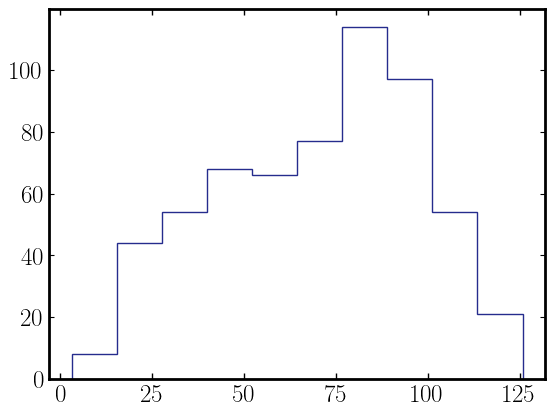

In [27]:
plt.hist(dist, histtype="step")

In [28]:
def get_gT_gX(eT, eX, rT, rX, w, dist, ang_bin_edges):
    eT_list = []
    eX_list = []
    rT_list = []
    rX_list = []
    eT_std_list = []
    eX_std_list = []
    for i in range(len(ang_bin_edges) - 1):
        mask = (dist >= ang_bin_edges[i]) & (dist < ang_bin_edges[i + 1])

        assert np.sum(mask) > 0, f"No data in bin {i} with edges {ang_bin_edges[i]} and {ang_bin_edges[i + 1]}"
        eT_sum = np.sum(eT[mask] * w[mask])
        eX_sum = np.sum(eX[mask] * w[mask])
        rT_sum = np.sum(rT[mask])
        rX_sum = np.sum(rX[mask])
        eT_list.append(eT_sum)
        eX_list.append(eX_sum)
        rT_list.append(rT_sum)
        rX_list.append(rX_sum)

        eT_std_list.append(np.std(eT[mask]))
        eX_std_list.append(np.std(eX[mask]))

    gT = np.array(eT_list) / np.array(rT_list) 
    gX = np.array(eX_list) / np.array(rX_list)
    gT_std = np.array(eT_std_list) / np.abs(np.array(rT_list))
    gX_std = np.array(eX_std_list) / np.abs(np.array(rX_list))
    return gT, gX, gT_std, gX_std

In [29]:
ang_bin_edges = np.linspace(5, 50., 5) 
ang_bin_mid = 0.5 * (ang_bin_edges[1:] + ang_bin_edges[:-1])
gT, gX, gT_std, gX_std = get_gT_gX(eT, eX, rT, rX, w, dist, ang_bin_edges)

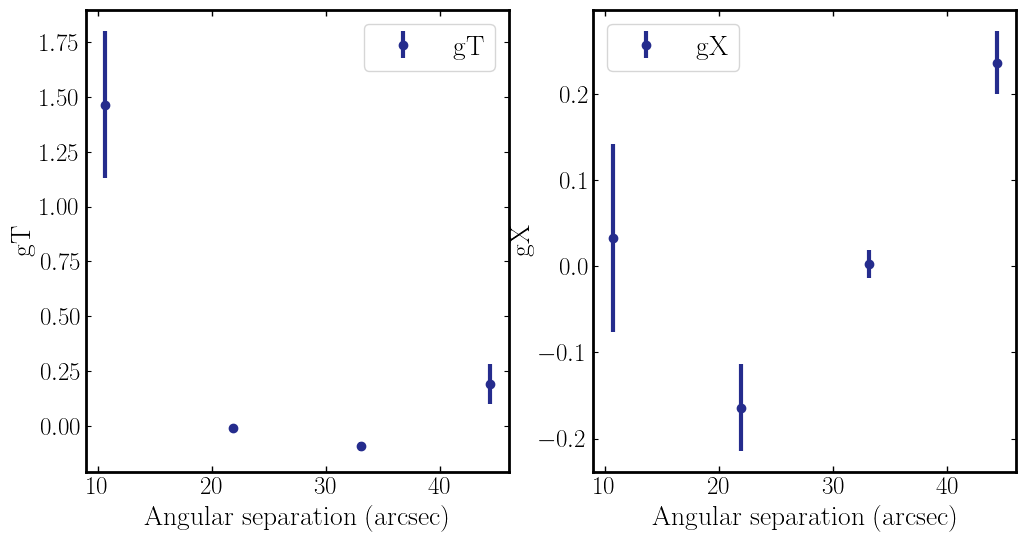

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].errorbar(
    ang_bin_mid,
    gT,
    yerr=gT_std,
    fmt="o",
    label="gT",
)
axes[0].set_xlabel("Angular separation (arcsec)")
axes[0].set_ylabel("gT")
axes[0].legend()
axes[1].errorbar(
    ang_bin_mid,
    gX,
    yerr=gX_std,
    fmt="o",
    label="gX",
)
axes[1].set_xlabel("Angular separation (arcsec)")
axes[1].set_ylabel("gX")
axes[1].legend()